# 01

**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[이론 + 실습]** Clip 02. LangGraph 필수 구성요소

## State (상태)

State 는 Agent의 현재 상태를 나타내는 데이터 구조이며, 주로 `TypedDict`, Pydantic `BaseModel` 을 사용합니다.


### 1. `TypedDict` , Pydantic `BaseModel` 이해하기

In [1]:
from typing import TypedDict

class User(TypedDict):
    id: int
    name: str
    email: str

user1: User = {
    'id': 1,
    'name': 'khj',
    'email': 'rkdguswlsla@gmail.com'
}
print(user1)

{'id': 1, 'name': 'khj', 'email': 'rkdguswlsla@gmail.com'}


In [2]:
user1: User = {
    'id': 1,
    'name': 123,
    'email': 'rkdguswlsla@gmail.com'
}
print(user1)

{'id': 1, 'name': 123, 'email': 'rkdguswlsla@gmail.com'}


In [1]:
from pydantic import BaseModel
## 3.11.2 version unavailable.
## so, upgrade to 3.13.5 with conda

class User(BaseModel):
    id: int
    name: str
    email: str

user_data = {
    'id': 1,
    'name': 'khj',
    'email': 'rkdguswlsla@gmail.com'
}

user1 = User(**user_data)
print(user1)

id=1 name='khj' email='rkdguswlsla@gmail.com'


In [3]:
user_data = {
    'id': 1,
    'name': 123,
    'email': 'khjsla@gmail.com'
}

user = User(**user_data)
print(user)

ValidationError: 1 validation error for User
name
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type

- 잘못된 데이터 타입이라면 오류 메시지를 반환

### 2. 상태 - Graph Schema 지정하기

State(상태) 라는 것은 **그래프의 스키마**와 상태에 업데이트를 적용하는 방법을 지정하는 **리듀서 함수**로 구성됨

- 에이전트를 구현하게 될 때, <u>**에이전트가 가지고 있어야 할 정보**</u>를 상태를 통해 업데이트 해주는 작업을 진행

- 아래 예시에서는 기본적으로 사용자의 질문과 답변을 정해진 데이터 구조(State)에 맞춰 입력 받고 반환하는 것

In [8]:
# StateGraph 등 사용하려면 langgraph 설치 필요
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [7]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# (사용자) 입력을 위한 스키마 정의
class InputState(TypedDict):
    question: str


# (ai) 출력을 위한 스키마 정의
class OutputState(TypedDict):
    answer: str


# 입력과 출력을 합한 종합 스키마 정의
class OverallState(InputState, OutputState):
    pass

In [9]:
# 입력을 처리하고 답변을 생성하는 노드 정의
def answer_node(state: InputState):
    # Example answer and an extra key
    return {"answer": "bye", "question": state["question"]} # 상태 업데이트


graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
graph_builder.add_node(answer_node)  # 답변 노드 추가
graph_builder.add_edge(START, "answer_node")  # 시작 엣지 추가
graph_builder.add_edge("answer_node", END)  # 끝 엣지 추가
graph = graph_builder.compile()  # Compile the graph

# 입력 invoke 및 결과 출력
print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


/var/folders/vq/cklpfj457sg4n1tgp2dbvsf80000gn/T/ipykernel_56887/3779834567.py:7: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
/var/folders/vq/cklpfj457sg4n1tgp2dbvsf80000gn/T/ipykernel_56887/3779834567.py:7: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)


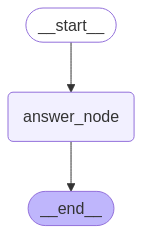

In [7]:
graph

### 3. 상태 - Reducer 지정하기

리듀서(Reducer)는 노드의 업데이트가 State(상태)에 적용되는 방식을 지정하는 함수


1 ) 리듀서가 지정되지 않은 경우

In [10]:
from typing_extensions import TypedDict

class State(TypedDict):
    value1: int
    value2: list[str]

2 ) 리듀서가 지정된 경우(`operator.add`)

In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    value1: int
    value2: Annotated[list[str], add] #append 'add'

3 ) 리듀서가 지정된 경우(`custom add`)

In [10]:
from typing_extensions import Annotated
from typing_extensions import TypedDict

# custom add func
def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    value1: int
    value2: Annotated[list[str], add]

4 ) 리듀서가 지정된 경우(`add_messages`)


- [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

    - 사용 예시

        ```python
        msgs1 = [HumanMessage(content="Hello", id="1")]
        msgs2 = [AIMessage(content="Hi there!", id="2")]
        add_messages(msgs1, msgs2)
        ```

In [12]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Nodes

노드는 Agent가 수행하는 논리를 구현하는 함수로 표현됨

### 1. 노드를 추가하는 방법

In [13]:
from langgraph.graph import StateGraph

builder = StateGraph(dict) #first graph


def my_node(state: dict):
    return {"results": f"Hello, {state['input']}!"}


def my_other_node(state: dict):
    return state


builder.add_node("my_node", my_node)
builder.add_node("other_node", my_other_node)

### 2. 노드의 기능을 구현하는 방법

In [16]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from operator import add

class State(TypedDict):
    messages: Annotated[list[str], add]


graph = StateGraph(State)

In [17]:
def chatbot(state: State):
    answer = "안녕하세요! 무엇을 도와드릴까요?"
    print("Answer : ", answer)

    return {"messages": [answer]} # state


graph.add_node("chatbot", chatbot)

In [18]:
graph.add_edge(START, "chatbot")
graph.add_edge("chatbot", END)
graph = graph.compile()

In [19]:
graph.invoke({"messages": ["안녕!"]})

Answer :  안녕하세요! 무엇을 도와드릴까요?


{'messages': ['안녕!', '안녕하세요! 무엇을 도와드릴까요?']}

## Edges

- 기본 엣지 (Normal Edges): 한 노드에서 다음 노드로 바로 이동

    ```python
    graph.add_edge("node_a", "node_b")
    ```


### Routing 

라우팅이란, **입력을 분류하고 후속 작업으로 안내하는 과정**으로 다음으로 진행되어야 할 스텝을 결정하여 보내주는 것

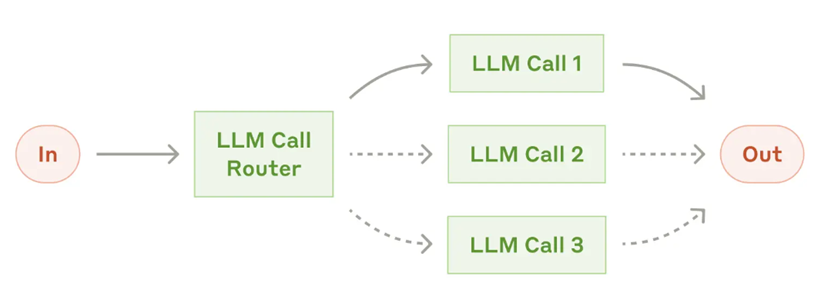

- 조건부 엣지 (Conditional Edges): 다음으로 이동할 노드를 결정하는 함수를 호출하여 결과에 따라 이동

In [17]:
class State(TypedDict):
    input: str
    output: str

In [18]:
router_builder = StateGraph(State)

In [19]:
def routing_function(state: State):
    if state["input"] == "isroute":
        return True
    return False

In [20]:
router_builder.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})
#약간 lambda 같이 활용이 되넹

- 진입점 (Entry Point): 사용자 입력이 도착하면 호출할 노드

    ```python
    from langgraph.graph import START

    graph.add_edge(START, "node_a")
    ```





- 조건부 진입점 (Conditional Entry Point): 사용자 입력이 도착하면 호출할 노드를 결정하는 함수를 호출하여 결과에 따라 이동

    ```python
    graph.add_conditional_edges(START, routing_function, {True: "node_b", False: "node_c"})
    ```

# 02

**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 03. LangGraph 기본 사용법 - 그래프의 상태 업데이트

## 대화메시지 상태 업데이트하기

- `HumanMessage` : 사용자(사람)의 메시지

- `AIMessage` : AI(LLM)의 메시지

- `AnyMessage` : HumanMessage, AIMessage를 포함하는 메시지

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    # 노드 실행 시 state 업데이트 = 노드의 return 
    # return {"messages": new_message, "extra_field": 10} 
    return {"messages": messages + [new_message], "extra_field": 10}

`set_entry_point` : 그래프의 시작 노드를 지정하는 엣지 (START -> "node")

In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

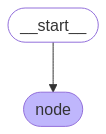

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("안녕")]})
result

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

In [6]:
result["messages"]

[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})]

## 대화메시지 상태 누적 업데이트하기

`from langgraph.graph.message import add_messages` 

[add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

- 사용 예시

    ```python
    msgs1 = [HumanMessage(content="Hello", id="1")]
    msgs2 = [AIMessage(content="Hi there!", id="2")]
    add_messages(msgs1, msgs2)
    ```

In [7]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

In [8]:
def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}

In [9]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

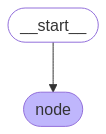

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
input_message = {"role": "user", "content": "안녕하세요."}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

안녕하세요.
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [12]:
result["messages"]

[HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='f2c0ac05-3ce6-4b2d-be2f-ebff4c5713d6'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='9e8b4beb-4f58-456d-9eba-2f54d9de8bce')]

## 부록) Graph 결과 호출 방식 정리하기

`invoke` : 하나의 요청에 대한 결과를 받을 때 까지 코드 실행 멈춤. 한번에 하나의 요청을 처리함

In [13]:
graph.invoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='55b91018-1766-41fc-a3e7-1e3a262188f1'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='38609c63-22a6-4645-932c-bba9e4ab5f2f')],
 'extra_field': 10}

`ainvoke` : 비동기 처리로 여러 요청을 동시에 보낼 수 있음

In [14]:
await graph.ainvoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='6940dfef-de1f-4ced-91f1-f4f91654a6de'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='089fee1d-ea16-432b-827c-ce2a0a4c1879')],
 'extra_field': 10}

`stream` : 중간 결과를 실시간으로 반환함

- `stream_mode="values"` 각 단계의 현재 상태 값 출력

In [15]:
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    print(chunk)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='0c09dd34-e262-4c59-8253-1c68da8bd1c8')]}
================================ Human Message =================================

안녕하세요.
{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='0c09dd34-e262-4c59-8253-1c68da8bd1c8'), AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='0e40e8ab-2dcc-4619-9c31-4744a17f5b8a')], 'extra_field': 10}
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


- (Default) `stream_mode="updates"` 각 단계의 상태 업데이트만 출력

In [16]:
for chunk in graph.stream({"messages": [input_message]}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'node': {'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='3a20857e-6a37-4dd8-b514-eb33b780ae7a'), 'extra_field': 10}}
node
안녕하세요! 무엇을 도와드릴까요?


- `stream_mode="messages"` 각 단계의 메시지 출력 

    - 메시지
    - 메타데이터

In [17]:
for chunk_msg, metadata in graph.stream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='d39ccc72-c9bb-4e73-948e-c0ad25039854'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node', 'start:node'), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:7bf5dbc5-bb4e-e12d-84d8-feb9e26b5993'}
node


`astream` : 비동기 방식으로 스트리밍 처리

In [18]:
async for chunk_msg, metadata in graph.astream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='ff77916a-a34d-4ea3-9eeb-225ed3b70984'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node', 'start:node'), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:ae21d541-c5c9-ebf2-8ad6-bf791412153c'}
node


# 03

**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 04. LangGraph 기본 사용법 - 노드와 엣지 연결

## 노드와 엣지 연결하기

In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

In [2]:
def step_1(state: State):
    return {"value_1": state["value_1"]}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}

In [3]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 엣지 추가
graph_builder.add_edge(START, "step_1") # START ->1
graph_builder.add_edge("step_1", "step_2") # 1-> 2
graph_builder.add_edge("step_2", "step_3") # 2->3

In [4]:
graph = graph_builder.compile()

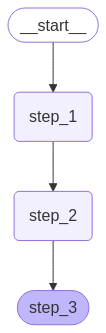

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"value_1": "fadgdsge"})

{'value_1': 'fadgdsge b', 'value_2': 10}

## 한번에 연결하기(add_sequence)

In [7]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'c b', 'value_2': 10}

## 병렬로 연결하기

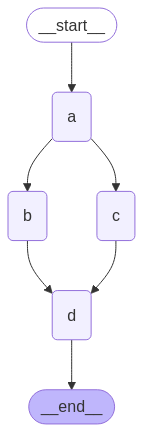

In [8]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add] # 업데이트 값이 뒤에 추가되도록 하는 operator.add 리듀서

In [9]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

In [10]:
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [11]:
# 엣지 추가
graph_builder.add_edge(START, "a")
graph_builder.add_edge("a", "b") # a -> b
graph_builder.add_edge("a", "c") # a -> c
graph_builder.add_edge("b", "d") # b -> d
graph_builder.add_edge("c", "d") # c -> d
graph_builder.add_edge("d", END)
graph = graph_builder.compile()

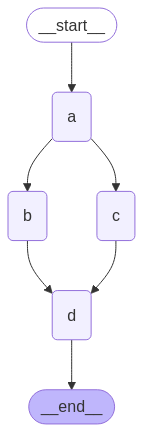

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"aggregate":[]})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

## 조건부 엣지 병렬 연결하기

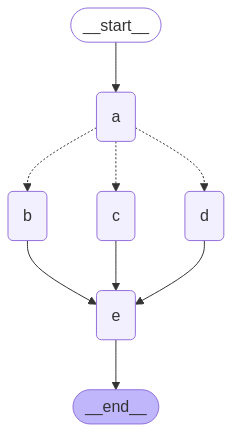

In [14]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which: str

In [15]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

In [16]:
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)
graph_builder.add_node(e)
graph_builder.add_edge(START, "a")

In [17]:
# bc 혹은 cd 로 라우트를 결정하는 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
graph_builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)

In [18]:
for node in intermediates:
    graph_builder.add_edge(node, "e")

graph_builder.add_edge("e", END)
graph = graph_builder.compile()

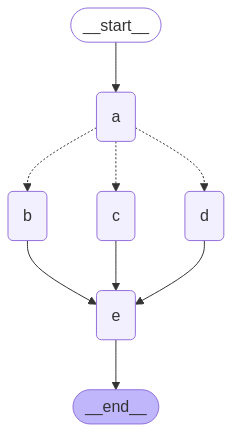

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [21]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 05. LangGraph 기본 사용법 - 조건과 반복

## 1. 조건에 따른 반복 처리하기

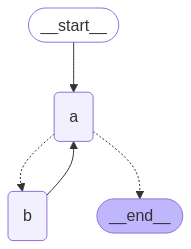

In [1]:
import operator
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [2]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)

In [3]:
def route(state: State):
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "a")
graph = graph_builder.compile()

In [8]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

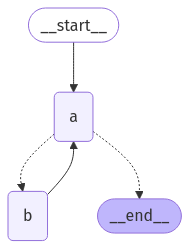

In [9]:
import requests, zlib, base64
from IPython.display import Image

# Mermaid 코드 추출
code = graph.get_graph().draw_mermaid()

# 압축·인코딩 후 Kroki 요청
encoded = base64.urlsafe_b64encode(zlib.compress(code.encode())).decode()
url = f"https://kroki.io/mermaid/png/{encoded}"
resp = requests.get(url)
display(Image(resp.content))

In [10]:
graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

- GraphRecursionError 로 에러를 반환하는 방법

In [11]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, config={"recursion_limit": 4})
except GraphRecursionError: # 반복 종료 조건에 도달할 수 없는 경우
    print("Recursion Error")

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Recursion Error


## 2. 조건에 따른 반복 처리하기 (더 복잡한 노드와 엣지 연결)

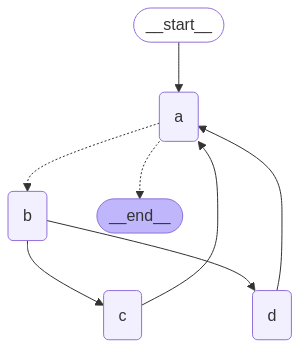

In [12]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [13]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["D"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [14]:
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge(["c", "d"], "a")
graph = graph_builder.compile()

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node C 처리 중 현재 상태값 : ['A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D']
Node B 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A']
Node C 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


## 3. 사용자 입력에 따른 반복 조건 설정하기

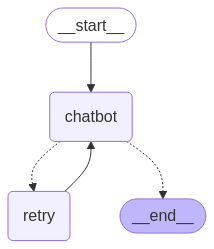

In [20]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    human_messages: Annotated[list[HumanMessage], add_messages]
    ai_messages: Annotated[list[AIMessage], add_messages]
    retry_num : int

In [19]:
def chatbot(state:State):
    retry_num = state["retry_num"]
    user_input = input(f"(현재 {retry_num}번째 답변) 사용자 입력: ")
    ai_message = AIMessage(f"{retry_num}번째 답변중!")

    return {"human_messages": [HumanMessage(content=user_input)], "ai_messages": [ai_message]}

def retry(state: State):
    return {"retry_num" : state["retry_num"] + 1}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("retry", retry)

In [20]:
def route(state: State):
    if "반복" in state["human_messages"][-1].content:
        return "retry"
    else:
        return END


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route)
graph_builder.add_edge("retry", "chatbot")
graph = graph_builder.compile()

In [22]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for chunk in graph.stream({"human_messages" : "반복", "retry_num": 0}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='73d7cb0c-144e-426c-a47c-46dd26e79f2f')], 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='5fa5a932-648f-4abd-945b-6b03cddba297')]}}
chatbot
{'retry': {'retry_num': 1}}
retry
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='eea39d17-d72e-441b-ad7e-6b8d851134ad')], 'ai_messages': [AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='ce50ed4f-5962-41ba-9b40-d4b5aab0337b')]}}
chatbot
{'retry': {'retry_num': 2}}
retry
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='73ee72b3-dce7-49aa-a8d8-965adc1025ac')], 'ai_messages': [AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='69759157-bf64-41ce-9bdc-34c94e30daf7')]}}
chatbot
{'retry': {'retry_num': 3}}
retry
{'chatbot': {'human_me

In [26]:
graph.invoke({"human_messages" : "반복", "retry_num": 0})

{'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='b811fac2-5a78-484a-a2dd-ebad06c02034'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='37f0798b-f29e-4bc2-8f3a-5f06f9e60e33'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='e10b6430-6a16-40d3-b409-1cbfb002cecc'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='dfc8b4f8-c719-40ef-8d20-b71fe1fd655a'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='0ad23a0c-87c6-489e-aa5f-85e149a19f60'),
  HumanMessage(content='그만', additional_kwargs={}, response_metadata={}, id='b18ef2b5-8b5a-4441-9568-19015bf77210')],
 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='b1e61f19-62a4-4ac1-9ab7-91fedd2aa38e'),
  AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='275e4a50-7d0b-4a1f-a5e1-8800f87fad39'),
  AIMessage(content='2번째